### Udacity Machine Learning : Capstone Project
Maryam Samim


In [129]:
#import all the needed libraries
import pandas as pd
import json
import numpy as np
import re
import matplotlib
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from numpy import concatenate
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.externals import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
#from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor
from numpy import concatenate
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

### Data Preprocessing Step
Here we will take the following steps to preprocess our dataset.
1. read the dataset file which is a csv format
2. get only the columns that may impact yor predictions
3. Removing the extremely low salary from my data 
4. get the rows where the primary_job column value contains teach in it so that we only get teachers data
5. take care of columns with 0 and then drop those rows.


In [130]:
# Reading the dataset from a csv file
input_data = pd.read_csv('nj_teachers_salaries_2016.csv')

#Getting all the columns except the first two which is the first/last name 
input_data = input_data.iloc[:,2:]
#Filtering the very low salary data which will
input_data = input_data[input_data['salary']>5000]
#Filtering the data to only get the rows where the primary_job has teach in it
input_data = input_data[input_data['primary_job'].str.contains('Teach')]
input_data = input_data.replace(0, np.NaN)
print('input_data shape before dropna: ',input_data.shape)
input_data.dropna(inplace=True)
print(input_data.shape)
input_data.head(n=2)

input_data shape before dropna:  (17474, 13)
(15866, 13)


,county,district,school,primary_job,fte,salary,certificate,subcategory,teaching_route,highly_qualified,experience_district,experience_nj,experience_total
27,Atlantic,Atlantic City,Uptown School Complex,Learning Disabilities Teacher Consultant,1.0,102540,Standard certificate,Special ed,Traditional,Doesn't need to be highly qualified,16.0,16.0,16.0
36,Atlantic,Atlantic City,New York Avenue School,Learning Disabilities Teacher Consultant,1.0,69941,Standard certificate,Special ed,Alternate,Doesn't need to be highly qualified,8.0,8.0,8.0


In [131]:

display(input_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15866 entries, 27 to 138714
Data columns (total 13 columns):
county                 15866 non-null object
district               15866 non-null object
school                 15866 non-null object
primary_job            15866 non-null object
fte                    15866 non-null float64
salary                 15866 non-null int64
certificate            15866 non-null object
subcategory            15866 non-null object
teaching_route         15866 non-null object
highly_qualified       15866 non-null object
experience_district    15866 non-null float64
experience_nj          15866 non-null float64
experience_total       15866 non-null float64
dtypes: float64(4), int64(1), object(8)
memory usage: 1.7+ MB


None

In [132]:
#statistical summary of the dataset
display(input_data.describe())

,fte,salary,experience_district,experience_nj,experience_total
count,15866.000000,15866.000000,15866.000000,15866.000000,15866.000000
mean,0.975022,68389.935459,9.658263,10.617106,10.892979
std,0.112213,17382.305932,7.701274,8.056071,8.221164
min,0.010000,5500.000000,1.000000,1.000000,1.000000
25%,1.000000,55153.250000,3.000000,4.000000,4.000000
50%,1.000000,63229.000000,8.000000,9.000000,9.000000
75%,1.000000,80359.000000,14.000000,15.000000,16.000000
max,1.000000,157383.000000,54.000000,54.000000,54.000000


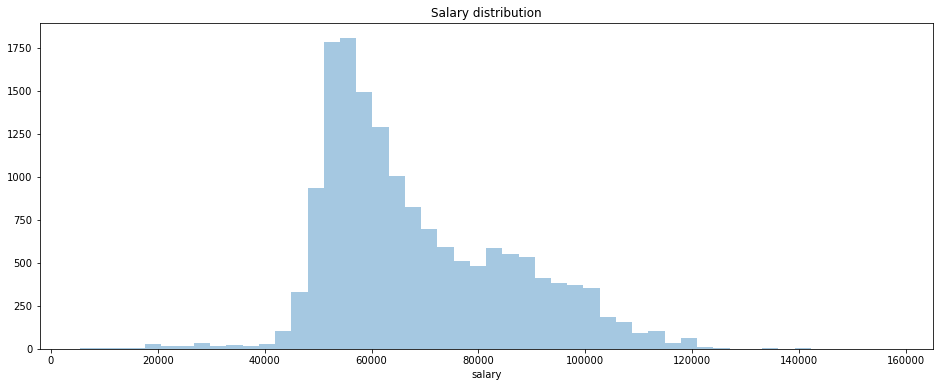

In [133]:
#Salary Distribution in dataset
#histogram
import seaborn as sns
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
h = sns.distplot(input_data['salary'], bins=50, kde=False)
plt.title('Salary distribution')
h.figure.set_size_inches(16,6)
plt.show()

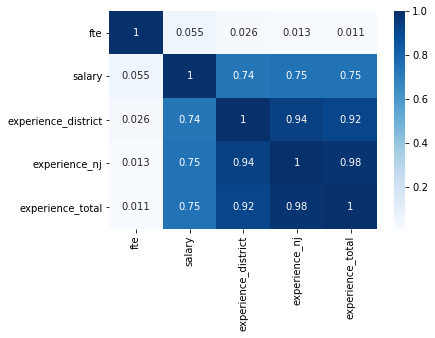

In [134]:

# visulize correlations of features with a heatmap# visuli 
plt.figure(figsize=(6,4))
sns.heatmap(input_data.corr(),annot=True, cmap="Blues")
plt.show()


In [135]:
display([x for x in input_data['certificate'].unique()])

['Standard certificate',
 'CE',
 'Provisional',
 'CEAS',
 'Emergency',
 'Non Citizen',
 'X']

In [136]:
# to see what get_dummy's output is :
input_data2 = pd.get_dummies(input_data['certificate'], prefix='certificate')
display(input_data2.tail())

,certificate_CE,certificate_CEAS,certificate_Emergency,certificate_Non Citizen,certificate_Provisional,certificate_Standard certificate,certificate_X
138684,0,0,0,0,1,0,0
138685,0,1,0,0,0,0,0
138689,0,0,0,0,0,1,0
138694,0,0,0,0,0,1,0
138714,0,0,0,0,0,1,0


In [137]:
#Using one hot encoder for my categorical data 

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
ohe= preprocessing.OneHotEncoder()

#there are some blanks in our certificate column, so replace by word blank where
# we will label encode them anyway 
input_data.certificate.fillna(value='blank', inplace=True)
input_data.certificate.replace(np.inf, 0)
input_data.fte.fillna(value=0, inplace=True)
input_data.fte.replace(np.inf, 0)
input_data.salary.fillna(value=0, inplace=True)
input_data.salary.replace(np.inf, 0)
input_data.experience_district.replace(np.inf, 0)
input_data.experience_nj.fillna(value=0, inplace=True)
input_data.experience_nj.replace(np.inf, 0)
input_data.experience_total.fillna(value=0, inplace=True)
input_data.experience_total.replace(np.inf, 0)
input_data = pd.concat([input_data,pd.get_dummies(input_data['certificate'], prefix='certificate')],axis=1)
input_data = pd.concat([input_data,pd.get_dummies(input_data['primary_job'], prefix='primary_job')],axis=1)
input_data = pd.concat([input_data,pd.get_dummies(input_data['subcategory'], prefix='subcategory')],axis=1)
input_data = pd.concat([input_data,pd.get_dummies(input_data['teaching_route'], prefix='teaching_route')],axis=1)
input_data = pd.concat([input_data,pd.get_dummies(input_data['highly_qualified'], prefix='highly_qualified')],axis=1)

display(input_data.head())

,county,district,school,primary_job,fte,salary,certificate,subcategory,teaching_route,highly_qualified,...,teaching_route_Traditional,teaching_route_X,highly_qualified_Doesn't need to be highly qualified,"highly_qualified_Highly qualified, House Matrix",highly_qualified_Highly qualified. Has 30 credits in content area.,highly_qualified_Highly qualified. Has gradate or undergraduate degree in subject area.,highly_qualified_Highly qualified. National Board Certified.,highly_qualified_Highly qualified. Passed the Praxis/NTE,highly_qualified_Nationally Board Certified,highly_qualified_Not highly qualified
27,Atlantic,Atlantic City,Uptown School Complex,Learning Disabilities Teacher Consultant,1.0,102540,Standard certificate,Special ed,Traditional,Doesn't need to be highly qualified,...,1,0,1,0,0,0,0,0,0,0
36,Atlantic,Atlantic City,New York Avenue School,Learning Disabilities Teacher Consultant,1.0,69941,Standard certificate,Special ed,Alternate,Doesn't need to be highly qualified,...,0,0,1,0,0,0,0,0,0,0
73,Atlantic,Atlantic City,Sovereign Avenue School,Learning Disabilities Teacher Consultant,1.0,100319,Standard certificate,Special ed,Traditional,Doesn't need to be highly qualified,...,1,0,1,0,0,0,0,0,0,0
112,Atlantic,Atlantic City,Atlantic City High School,Learning Disabilities Teacher Consultant,1.0,115768,Standard certificate,Special ed,Traditional,Doesn't need to be highly qualified,...,1,0,1,0,0,0,0,0,0,0
177,Atlantic,Atlantic City,District Office,Teacher Leader,1.0,121454,Standard certificate,General ed,Traditional,Highly qualified. Passed the Praxis/NTE,...,1,0,0,0,0,0,0,1,0,0


In [138]:
input_data = input_data.drop(['county','district','school','primary_job','certificate','subcategory','teaching_route','highly_qualified'], axis=1)


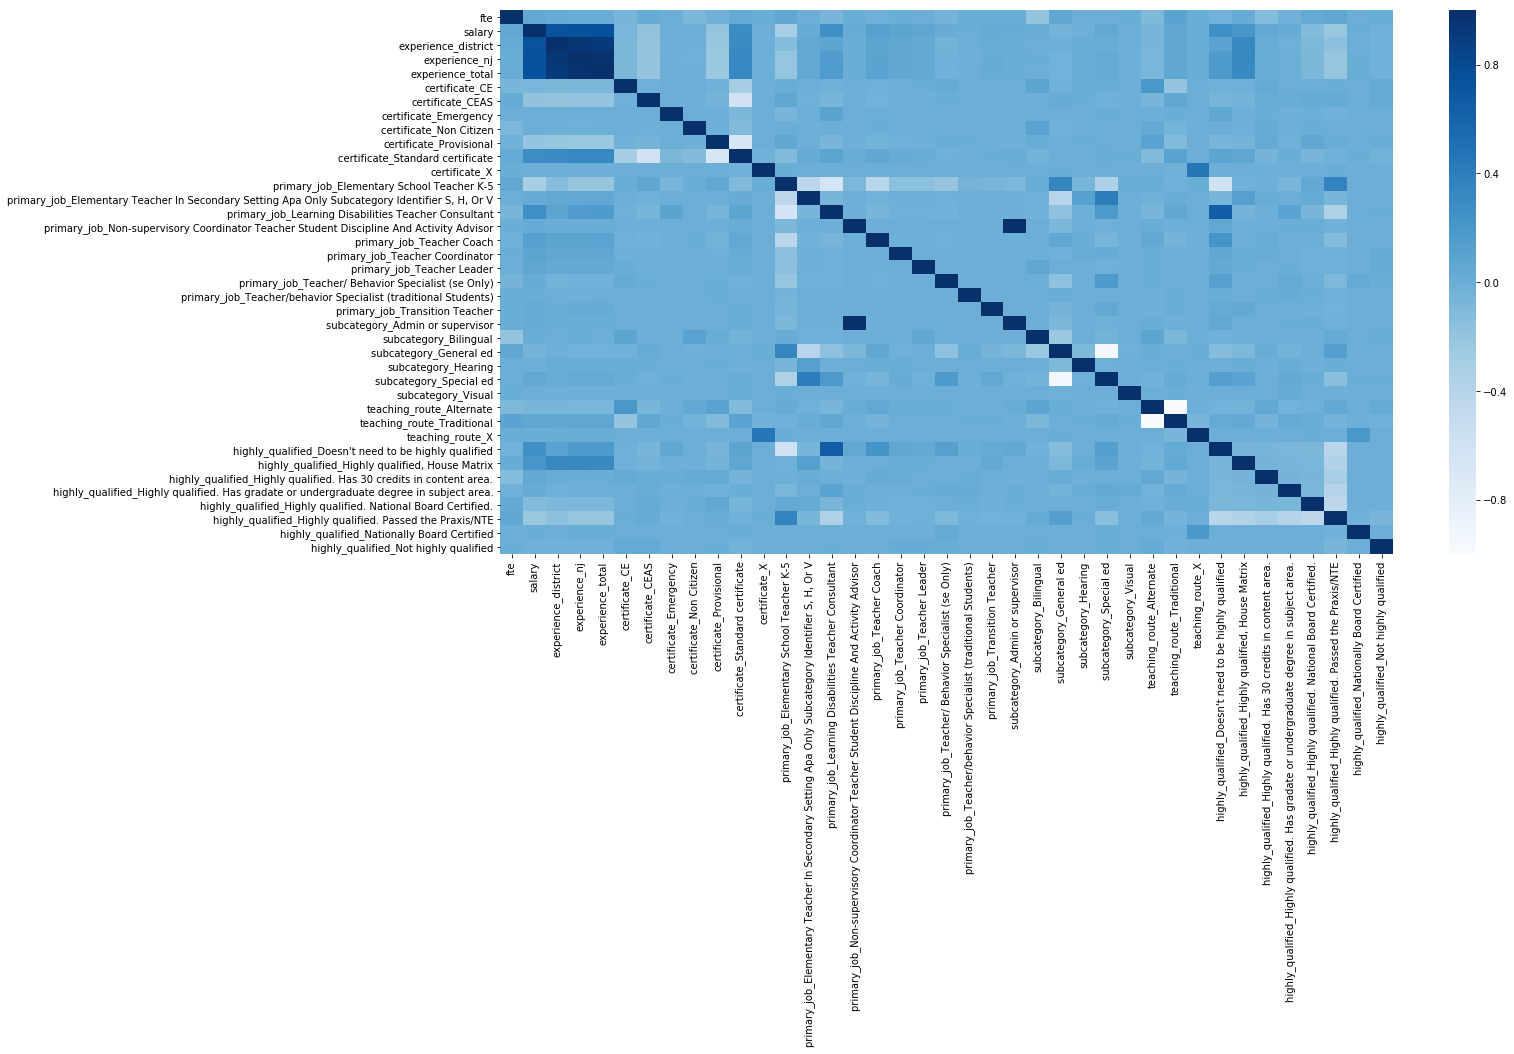

In [139]:
# visulize correlations of features with a heatmap# visuli 
plt.figure(figsize=(20,10))
sns.heatmap(input_data.corr(), cmap="Blues")
plt.show()

In [140]:
input_data2 = input_data
scaling = MinMaxScaler(feature_range=(0,1)).fit(input_data2)
input_data2 = pd.DataFrame(scaling.transform(input_data2))

In [141]:

input_data = input_data[input_data['salary']>5000]
y= input_data['salary']
x=input_data.drop(['salary'], axis=1) 
#split your dataset to training and testing data

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0) 

In [142]:
x_train.head()

,fte,experience_district,experience_nj,experience_total,certificate_CE,certificate_CEAS,certificate_Emergency,certificate_Non Citizen,certificate_Provisional,certificate_Standard certificate,...,teaching_route_Traditional,teaching_route_X,highly_qualified_Doesn't need to be highly qualified,"highly_qualified_Highly qualified, House Matrix",highly_qualified_Highly qualified. Has 30 credits in content area.,highly_qualified_Highly qualified. Has gradate or undergraduate degree in subject area.,highly_qualified_Highly qualified. National Board Certified.,highly_qualified_Highly qualified. Passed the Praxis/NTE,highly_qualified_Nationally Board Certified,highly_qualified_Not highly qualified
91555,1.0,14.0,14.0,14.0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
19563,1.0,1.0,1.0,1.0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
46740,1.0,2.0,3.0,3.0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
10867,1.0,8.0,8.0,8.0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
19381,1.0,3.0,5.0,5.0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0


In [143]:

from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler(feature_range=(0,1)).fit(x_train)
x_train = scaling.transform(x_train)
x_test = scaling.transform(x_test)
(pd.DataFrame(x_train)).head()

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,1.0,0.245283,0.245283,0.245283,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.018868,0.037736,0.037736,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.132075,0.132075,0.132075,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.037736,0.075472,0.075472,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [144]:
#  Create a decision tree regressor and fit it to the training set
dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(x_train, y_train)
#  Report the score of the prediction using the testing set
score = dt_regressor.score(x_test, y_test)
#print ('The score is ', score)
y_pred = dt_regressor.predict(x_test)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse)
print('Test r^2 score: %.3f' % r2_score(y_test, y_pred))

Test RMSE: 12088.910
Test r^2 score: 0.546


In [145]:
regressor = RandomForestRegressor()
regressor.fit(x_train, y_train)

# Predicting a new result
y_pred = regressor.predict(x_test)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse)
print('Test r^2 score: %.3f' % r2_score(y_test, y_pred))


Test RMSE: 10852.621
Test r^2 score: 0.634


In [146]:

from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [15,20,25],
    'max_features': [6,7,8],
    'min_samples_leaf': [2,3],
    'min_samples_split': [20,22,24],
    'n_estimators': [150,180, 190]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
gs = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [147]:
gs = gs.fit(x_train, y_train)


Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 486 out of 486 | elapsed:  1.8min finished


In [148]:
print(gs.best_score_)
print(gs.best_params_)

0.6550176647601669
{'bootstrap': True, 'n_estimators': 150, 'max_features': 8, 'min_samples_leaf': 2, 'min_samples_split': 20, 'max_depth': 25}


In [149]:
#this will be out best model for the random Forest

my_model =gs.best_estimator_
y_p = my_model.predict(x_test)
rmse = math.sqrt(mean_squared_error(y_test, y_p))
print('Test RMSE: %.3f' % rmse)
print('Test r^2 score: %.3f' % r2_score(y_test, y_p))

Test RMSE: 10384.610
Test r^2 score: 0.665


In [151]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

svr_regressor= SVR(kernel='linear',cache_size=7000)
svr_regressor.fit(x_train, y_train)

param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
# Create a based model
svr_reg = SVR()
# Instantiate the grid search model
gs = GridSearchCV(estimator = svr_reg, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [152]:
gs = gs.fit(x_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  2.4min finished


In [153]:
print(gs.best_score_)
print(gs.best_params_)

0.6089979215496113
{'kernel': 'linear', 'C': 1000}


In [154]:
my_model =gs.best_estimator_
y_p = my_model.predict(x_test)
rmse = math.sqrt(mean_squared_error(y_test, y_p))
print('Test RMSE: %.3f' % rmse)
print('Test r^2 score: %.3f' % r2_score(y_test, y_p))

Test RMSE: 11197.548
Test r^2 score: 0.611


In [156]:
#In this section I am trying a neural network for this regression to just see how it performs.
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
def baseline_model():
    model = Sequential()
    model.add(Dense(6, input_dim=38, kernel_initializer='normal', activation='relu'))
    model.add(Dense(4, kernel_initializer='normal', activation='relu'))
    model.add(Dense(2, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# fix random seed for reproducibility
seed = 7

np.random.seed(seed)
estimators = []
estimators.append(('minmax', MinMaxScaler(feature_range=(-1, 1))))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=30, batch_size=5, verbose=2)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=2, random_state=seed)
results = cross_val_score(pipeline, x_train, y_train, cv=kfold)
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Epoch 1/30
 - 2s - loss: 4611676096.4437
Epoch 2/30
 - 1s - loss: 1433533533.1235
Epoch 3/30
 - 1s - loss: 390666072.7565
Epoch 4/30
 - 1s - loss: 367235798.5648
Epoch 5/30
 - 1s - loss: 346143100.2527
Epoch 6/30
 - 1s - loss: 326101649.9549
Epoch 7/30
 - 1s - loss: 308215779.7991
Epoch 8/30
 - 1s - loss: 290719563.3665
Epoch 9/30
 - 1s - loss: 274474425.0011
Epoch 10/30
 - 1s - loss: 259400880.7071
Epoch 11/30
 - 1s - loss: 245513177.9616
Epoch 12/30
 - 1s - loss: 232178556.7554
Epoch 13/30
 - 1s - loss: 220001645.9322
Epoch 14/30
 - 1s - loss: 208667901.9192
Epoch 15/30
 - 1s - loss: 198702472.7853
Epoch 16/30
 - 1s - loss: 189528855.8594
Epoch 17/30
 - 1s - loss: 181199987.6488
Epoch 18/30
 - 1s - loss: 173786858.6566
Epoch 19/30
 - 1s - loss: 167048795.7060
Epoch 20/30
 - 1s - loss: 161128590.8788
Epoch 21/30
 - 1s - loss: 155680885.2842
Epoch 22/30
 - 1s - loss: 150723316.4159
Epoch 23/30
 - 1s - loss: 146404654.7745
Epoch 24/30
 - 1s - loss: 142369609.5879
Epoch 25/30
 - 1s - los

In [157]:
print (pipeline.fit(x_train, y_train))

Epoch 1/30
 - 3s - loss: 2605641336.0961
Epoch 2/30
 - 2s - loss: 367122184.8346
Epoch 3/30
 - 3s - loss: 313459016.5460
Epoch 4/30
 - 2s - loss: 267710741.9734
Epoch 5/30
 - 2s - loss: 229950875.2481
Epoch 6/30
 - 2s - loss: 199710171.2105
Epoch 7/30
 - 2s - loss: 176924725.2223
Epoch 8/30
 - 2s - loss: 160295286.0153
Epoch 9/30
 - 2s - loss: 148212097.2188
Epoch 10/30
 - 2s - loss: 138653114.9264
Epoch 11/30
 - 2s - loss: 131425766.2880
Epoch 12/30
 - 2s - loss: 126702565.5545
Epoch 13/30
 - 2s - loss: 123625655.6202
Epoch 14/30
 - 2s - loss: 121492686.2263
Epoch 15/30
 - 2s - loss: 119675780.5881
Epoch 16/30
 - 3s - loss: 118680190.7809
Epoch 17/30
 - 2s - loss: 117828026.3671
Epoch 18/30
 - 2s - loss: 117129416.7157
Epoch 19/30
 - 2s - loss: 116679453.3918
Epoch 20/30
 - 2s - loss: 116320924.9268
Epoch 21/30
 - 2s - loss: 115963815.7690
Epoch 22/30
 - 2s - loss: 115673820.1663
Epoch 23/30
 - 2s - loss: 115371020.0900
Epoch 24/30
 - 2s - loss: 115368285.1274
Epoch 25/30
 - 2s - loss

In [158]:
#use my neural network model to predict the resutl for test_data x_test
y_pred = pipeline.predict(x_test)

In [159]:
from numpy import concatenate
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse)
print('Test r^2 score: %.3f' % r2_score(y_test, y_pred))

Test RMSE: 11111.973
Test r^2 score: 0.617
